**Telecom - Finding customers with sub-optimal tariffs**

Task:


Find customers who:


 a ) are overpaying on current tariffs;


 b ) save money by switching to a more expensive tariff







**Data description:**


Dataset: `/datasets/telecom_dataset.csv`.


**Columns:**


- **user_id** - client identifier
- **date** - date of statistics
- **direction** - directionof calls:
- `out` - outgoing call
-`internal` - marker of internal and external calls
- **operator_id** - operator identifier
- **is_missed_call** - marker of missed calls
- **calls_count** - number of calls
-**call_duration** - duration of a call without waiting time
- **total_call_duration** - call duration including waiting time


Dataset:`/datasets/telecom_clients.csv`


**Columns:**


- **user_id** - client's identifier
- **tariff_plan** - client's tariff plan
- **date_start** - date of client's registration in the service





**Incoming and internal calls** - free of charge on all tariffs.

|Rate | Monthly fee (₽) | Operator surcharge (₽) | In-network outgoing (min) | Price over limit (₽/min) | Outgoing except domestic (₽/min ) |
|--------|----------------------|----------------------------|----------------------------|--------------------------|---------------------------------|
| A      | 4000                 | 50                         | 2000                       | 0.10                     | 0.3                             |
| B      | 2000                 | 150                        | 500                        | 0.15                     | 0.5                             |
| C      | 1000                 | 300                        | 0                          | 0.30                     | 0.7                             |


**Plan of work:**
1. Downloading and examining the data
- Interim findings
2. Data preprocessing:
- Pass processing
- Duplicate processing
- Anomaly handling
- Reconciliation to correct data types
- Other (based on problems found in the dataset)
- Interim conclusions
3- Exploratory data analysis:
- Identification and retrieval of active users
- Investigation of user costs (active users)
- Search for users who overpay for communication services
4. Statistical hypothesis testing
5. General conclusions and recommendations

# Downloading and examining data

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
from scipy.stats import shapiro, wilcoxon

pd.set_option('display.float_format', '{:,.3f}'.format)

import warnings
warnings.filterwarnings('ignore')

In [3]:
try:
      df_clients=pd.read_csv('https://code.s3.yandex.net/datasets/telecom_clients.csv')
except:
      df_clients = pd.read_csv('telecom_clients.csv')
try:
      df_calls=pd.read_csv('https://code.s3.yandex.net/datasets/telecom_dataset.csv')
except:
      df_calls = pd.read_csv('telecom_dataset.csv')

In [4]:
df_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB


There are gaps in the internal and operator_id columns. There is also a data type mismatch in the date and internal columns, as well as in operator_id.

In [5]:
df_calls['date'] = pd.to_datetime(df_calls['date']).dt.tz_localize(None)

df_calls['operator_id'] = df_calls['operator_id'].astype('Int64')

In [6]:
duplicate_count_calls = df_calls.duplicated().sum()

duplicate_count_calls

4900

4,900 duplicate records were found in the call data.

In [7]:
# Remove duplicates from call data
df_calls = df_calls.drop_duplicates()

duplicate_count_cleaned = df_calls.duplicated().sum()

print(f"After removing the duplicates, the following remains {duplicate_count_cleaned} .")

After removing the duplicates, the following remains 0 .


Let's look at the gaps in the operator_id column

In [8]:
missing_operator_analysis = df_calls[df_calls['operator_id'].isna()]['is_missed_call'].value_counts()

missing_operator_analysis

is_missed_call
True     7343
False     113
Name: count, dtype: int64

Most misses refer to missed calls (is_missed_call = True).
In case of a missed call, apparently the operator is not fixed, because the conversation did not take place. Let's leave these skips as they are for now.

In [9]:
df_clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      732 non-null    int64 
 1   tariff_plan  732 non-null    object
 2   date_start   732 non-null    object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB


There are no gaps. Let's convert the date_start column to the date/time format

In [10]:
df_clients['date_start'] = pd.to_datetime(df_clients['date_start'])

In [11]:
duplicates_check = df_clients.duplicated().unique()
duplicates_check

array([False])

No duplicates.

In [12]:
# Counting the number of unique customers
unique_clients = df_calls['user_id'].nunique()

# Counting the number of unique operators
unique_operators = df_calls['operator_id'].nunique()

unique_clients, unique_operators

(307, 1092)

Number of unique customers: 307


Number of unique operators: 1092

Let's look at the unique values in the df_clients dataframe:

In [13]:
total_unique_clients = df_clients['user_id'].nunique()

total_unique_tariffs = df_clients['tariff_plan'].nunique()

tariff_distribution = df_clients['tariff_plan'].value_counts()

print(f"Total number of unique customers: {total_unique_clients}")
print(f"Number of available tariffs: {total_unique_tariffs}")
print("Distribution of customers by tariffs:")
print(tariff_distribution)


Total number of unique customers: 732
Number of available tariffs: 3
Distribution of customers by tariffs:
tariff_plan
C    395
B    261
A     76
Name: count, dtype: int64


The number of unique clients in the two datasets is very different, let's check how many clients match between the datasets:

In [14]:
common_clients = df_clients['user_id'].isin(df_calls['user_id']).sum()  # Количество клиентов из df_clients, которые есть в df_calls

common_clients

307

It turns out that there are 425 extra clients in df_clients that are missing from the call data.
Perhaps these are clients who registered but did not make calls.

Let's verify that only one rate is assigned to each customer:

In [15]:
clients_with_multiple_tariffs = df_clients.groupby('user_id')['tariff_plan'].nunique()
multiple_tariff_clients = clients_with_multiple_tariffs[clients_with_multiple_tariffs > 1]

multiple_tariff_clients

Series([], Name: tariff_plan, dtype: int64)

Let's determine the minimum and maximum dates in the call data

In [16]:
min_date = df_calls['date'].min()
max_date = df_calls['date'].max()

min_date, max_date

(Timestamp('2019-08-02 00:00:00'), Timestamp('2019-11-28 00:00:00'))

The call data covers the period from August 2, 2019 through November 28, 2019.

Let's see if there are anomalies in call duration per day:

In [17]:
# Converting the time of calls from seconds to hours
df_calls['total_call_duration_hours'] = df_calls['total_call_duration'] / 60  

operators_over_24h = df_calls.groupby(['operator_id', 'date'])['total_call_duration_hours'].sum()

operators_over_limit = operators_over_24h[operators_over_24h > 24]

operators_over_limit

operator_id  date      
879896       2019-08-05   35.950
             2019-08-06   95.950
             2019-08-07   53.000
             2019-08-08   25.983
             2019-08-09   48.600
                           ...  
972410       2019-11-27   31.750
             2019-11-28   56.167
972412       2019-11-27   35.617
             2019-11-28   40.183
972460       2019-11-28   25.783
Name: total_call_duration_hours, Length: 7929, dtype: float64


Имеются операторы, наговорившие больше 24 часов за сутки, что невозможно.

In [18]:
total_operators = df_calls['operator_id'].nunique()

operators_exceeding_limit = operators_over_limit.index.get_level_values('operator_id').nunique()

percentage_exceeding = (operators_exceeding_limit / total_operators) * 100

operators_exceeding_list = operators_over_limit.index.get_level_values('operator_id').unique()

summary_df = pd.DataFrame({
    "Total operators": [total_operators],
    "Operators over the limit": [operators_exceeding_limit],
    "Percentage of excess (%)": [percentage_exceeding]
})

display(summary_df)

,Total operators,Operators over the limit,Percentage of excess (%)
0,1092,570,52.198



More than 50% of operators work more than 24 hours a day - a clear anomaly in the data.

In [19]:
# Operators with overload (more than 24 hours a day)
df_calls['total_call_duration_hours'] = df_calls['total_call_duration'] / 60  

operators_over_24h = df_calls.groupby(['operator_id', 'date'])['total_call_duration_hours'].sum()

operators_over_limit = operators_over_24h[operators_over_24h > 24]

operators_over_24h_list = operators_over_limit.index.get_level_values('operator_id').unique()

clients_with_overloaded_operators = df_calls[df_calls["operator_id"].isin(operators_over_24h_list)]["user_id"].nunique()

print(f"Number of unique customers using overload operators for more than 24 hours: {clients_with_overloaded_operators}")


Number of unique customers using overload operators for more than 24 hours: 169



So the problem is not related to individual customers, but is widespread.

In [20]:
# Filter calls from abnormal operators (more than 24 hours a day)
calls_from_overloaded_operators = df_calls[df_calls["operator_id"].isin(operators_over_24h_list)]

call_direction_distribution = calls_from_overloaded_operators["direction"].value_counts()

print("Allocating call destinations to abnormal operators:")
display(call_direction_distribution)


Allocating call destinations to abnormal operators:


direction
out    25972
in      9957
Name: count, dtype: int64

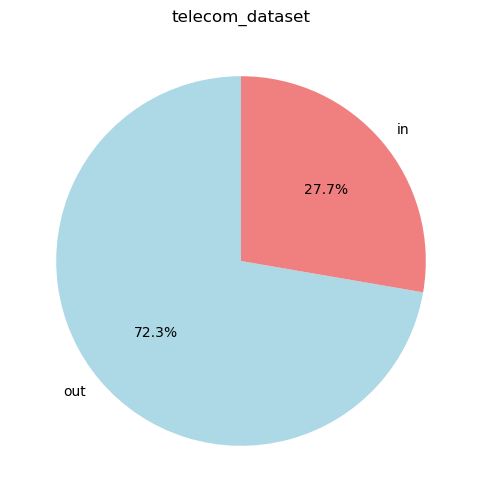

In [21]:
plt.figure(figsize=(6, 6))
call_direction_distribution.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightcoral'])
plt.title("telecom_dataset")
plt.ylabel('')
plt.show()


direction
in     10046
out     3027
Name: count, dtype: int64

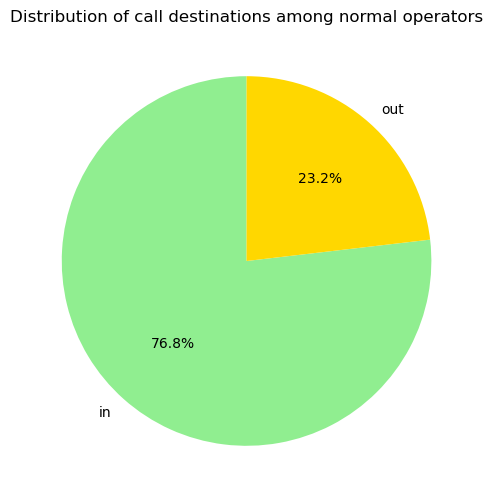

In [22]:
normal_operators = df_calls[~df_calls["operator_id"].isin(operators_over_24h_list)]

call_direction_distribution_normal = normal_operators["direction"].value_counts()

display(call_direction_distribution_normal)

plt.figure(figsize=(6, 6))
call_direction_distribution_normal.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['lightgreen', 'gold'])
plt.title("Distribution of call destinations among normal operators")
plt.ylabel('')  
plt.show()




- Abnormal operators have a predominance of outgoing calls.
- "Normal" operators have a predominance of incoming calls.
Abnormal operators may be automated systems or call centers because they make an unnaturally high number of outgoing calls.

In [23]:
# Average call duration at abnormal operators
mean_duration_anomalous = calls_from_overloaded_operators["total_call_duration"].mean()

# Average call duration for normal operators
mean_duration_normal = normal_operators["total_call_duration"].mean()

print(f"Average call duration at abnormal operators: {mean_duration_anomalous:.2f} minutes")
print(f"Average call duration for normal operators: {mean_duration_normal:.2f} minutes")


Average call duration at abnormal operators: 1503.00 minutes
Average call duration for normal operators: 204.42 minutes




- The average call length of abnormal operators is ~25 hours, which is unrealistic.
- The average call length of "normal" operators is ~3.5 hours, which also seems excessive.

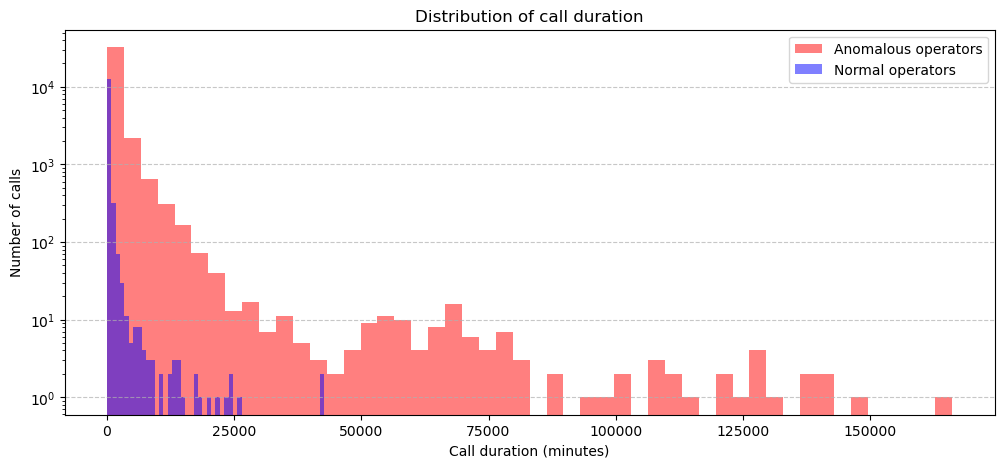

In [24]:
plt.figure(figsize=(12, 5))

plt.hist(calls_from_overloaded_operators["total_call_duration"], bins=50, alpha=0.5, label="Anomalous operators", color="red")

plt.hist(normal_operators["total_call_duration"], bins=50, alpha=0.5, label="Normal operators", color="blue")

plt.xlabel("Call duration (minutes)")
plt.ylabel("Number of calls")
plt.title("Distribution of call duration")
plt.legend()
plt.yscale("log")  # Logarithmic scale for better visibility
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()



 - Calls for abnormal operators (red histogram) are strongly shifted to the area of very large values.
- In normal operators (blue histogram) calls are more evenly distributed, but there are still long calls.
**Conclusion**:
There are clear errors in the recording of call duration. You can either contact the customer to clarify exactly how the data is recorded and whether the results can be interpreted differently.
In our case, I see no alternative to filtering the data (discard 52% of anomalous values).

In [25]:
df_calls_filtered = df_calls[~df_calls["operator_id"].isin(operators_over_24h_list)]

remaining_operators = df_calls_filtered["operator_id"].nunique()
remaining_calls = df_calls_filtered.shape[0]

print(f"After filtration there was {remaining_operators} unique operators.")
print(f"Number of call records after filtering: {remaining_calls}.")


After filtration there was 522 unique operators.
Number of call records after filtering: 13073.




**Data preprocessing conclusions:**


- Brought **dates** and **operator IDs** to the correct format.
- Removed**4900** duplicates, found**7456** omissions in ` operator_id`, most related to missed calls.
- Found out that there were **,732 records** in the customer database, but only**,307** actually made calls.
- Checked the tariffs - each customer ** hasonly one tariff**.
- **Found an anomaly**: More than 50% of operators work **more than24 hours a day**.


For this study it is important to note that only values exceeding **24 hours a day** will be considered abnormal, since the operator in this case is not one person, but one "communication channel", i.e. "one operator" can be several people working in shifts. Therefore, call uptime of up to 24 hours can be considered normal - for example, for support services working 24/7, or customers working with many time zones.



# Exploratory data analysis

**Let's look at the behavior of the remaining customers**

<Figure size 1000x500 with 0 Axes>

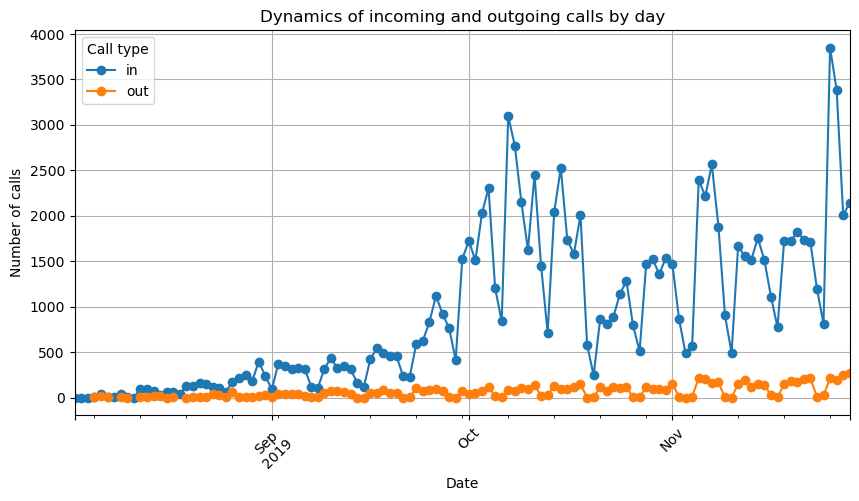

<Figure size 1000x500 with 0 Axes>

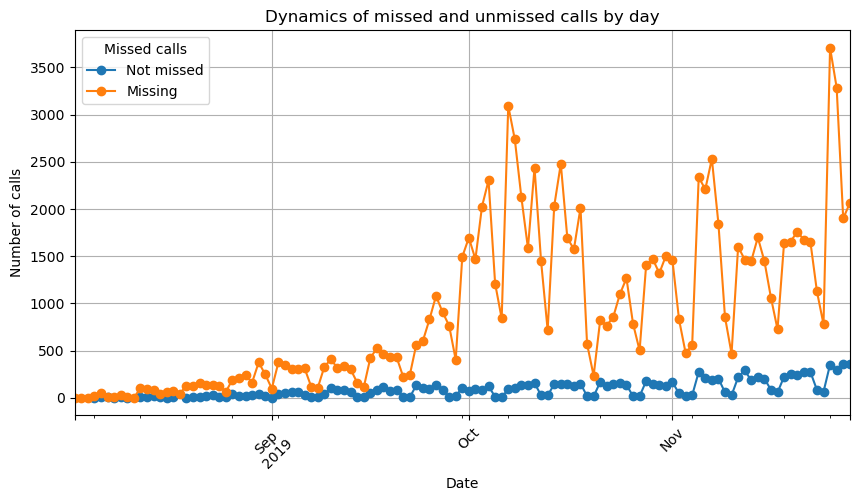

In [26]:
daily_call_counts = df_calls_filtered.groupby(['date', 'direction'])['calls_count'].sum().unstack()

# Graph of incoming and outgoing call dynamics by day
plt.figure(figsize=(10, 5))
daily_call_counts.plot(kind='line', marker='o', figsize=(10, 5))
plt.title("Dynamics of incoming and outgoing calls by day")
plt.xlabel("Date")
plt.ylabel("Number of calls")
plt.legend(title="Call type")
plt.xticks(rotation=45)
plt.grid()
plt.show()

daily_missed_calls = df_calls_filtered.groupby(['date', 'is_missed_call'])['calls_count'].sum().unstack()

# Graph of missed and unmissed calls by day
plt.figure(figsize=(10, 5))
daily_missed_calls.plot(kind='line', marker='o', figsize=(10, 5))
plt.title("Dynamics of missed and unmissed calls by day")
plt.xlabel("Date")
plt.ylabel("Number of calls")
plt.legend(title="Missed calls", labels=["Not missed", "Missing"])
plt.xticks(rotation=45)
plt.grid()
plt.show()


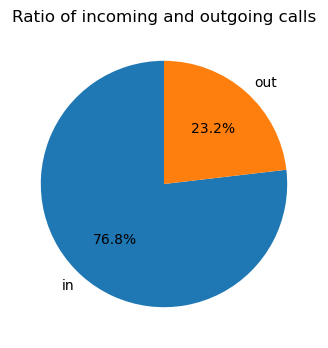

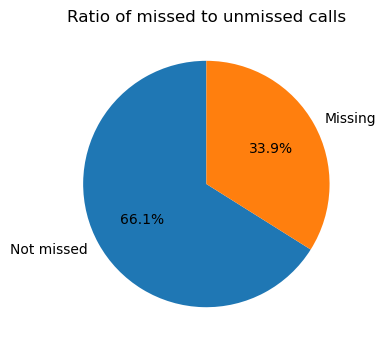

In [27]:
call_direction_counts = df_calls_filtered['direction'].value_counts()

# Graph of the ratio of incoming to outgoing calls
plt.figure(figsize=(6, 4))
plt.pie(call_direction_counts, labels=call_direction_counts.index, autopct='%1.1f%%', startangle=90)
plt.title("Ratio of incoming and outgoing calls")
plt.show()

missed_calls_counts = df_calls_filtered['is_missed_call'].value_counts()

# Schedule of missed and unmissed calls
plt.figure(figsize=(6, 4))
plt.pie(missed_calls_counts, labels=["Not missed", "Missing"], autopct='%1.1f%%', startangle=90)
plt.title("Ratio of missed to unmissed calls")
plt.show()


- There are more incoming calls than outgoing calls.
- There are sudden spikes in the number of calls - perhaps it is weekends, holidays or technical failures.
- Missed calls increase on peak days, which may indicate operator overload.

Let's look at the distribution of calls by day of the week:

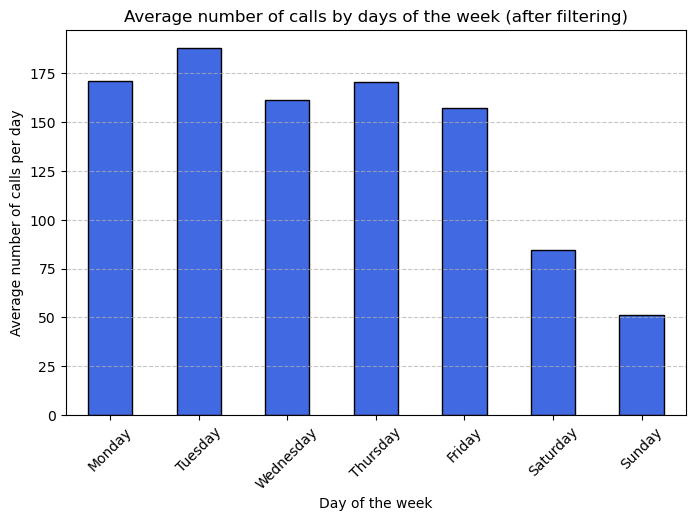

In [28]:
df_calls_filtered['weekday'] = df_calls_filtered['date'].dt.day_name()

calls_by_weekday_avg = df_calls_filtered.groupby('weekday')['calls_count'].sum() / df_calls_filtered['date'].nunique()

calls_by_weekday_avg = calls_by_weekday_avg.reindex(
    ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
)

plt.figure(figsize=(8, 5))
calls_by_weekday_avg.plot(kind='bar', color='royalblue', edgecolor='black')
plt.title("Average number of calls by days of the week (after filtering)")
plt.xlabel("Day of the week")
plt.ylabel("Average number of calls per day")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

The decline in the number of calls on weekends is clearly visible.

Let's look at the distribution of data over time depending on the tariff:

In [29]:
df_calls_filtered = df_calls_filtered.merge(df_clients[['user_id', 'tariff_plan']], on="user_id", how="left")
df_calls.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,total_call_duration_hours
0,166377,2019-08-04,in,False,<NA>,True,2,0,4,0.067
1,166377,2019-08-05,out,True,880022,True,3,0,5,0.083
2,166377,2019-08-05,out,True,880020,True,1,0,1,0.017
3,166377,2019-08-05,out,True,880020,False,1,10,18,0.300
4,166377,2019-08-05,out,False,880022,True,3,0,25,0.417


<Figure size 1000x500 with 0 Axes>

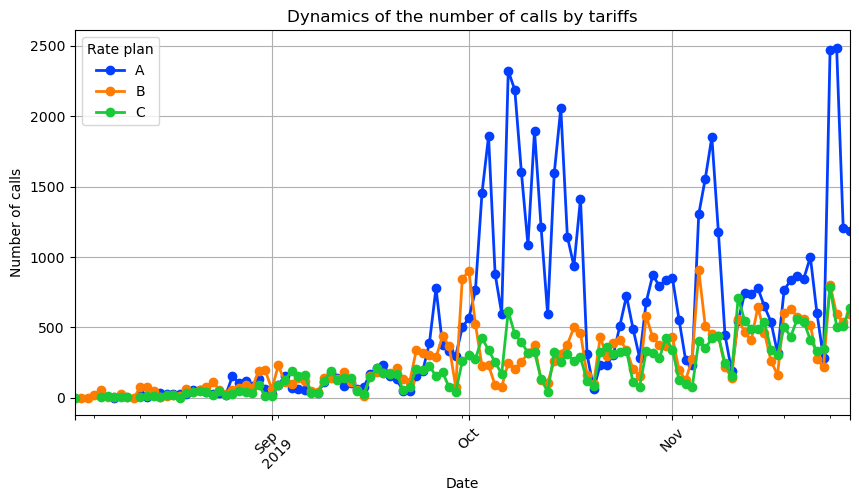

In [30]:

calls_by_tariff_over_time = df_calls_filtered.groupby(['date', 'tariff_plan'])['calls_count'].sum().unstack()

colors = sns.color_palette("bright", n_colors=len(calls_by_tariff_over_time.columns))

plt.figure(figsize=(10, 5))
calls_by_tariff_over_time.plot(kind='line', marker='o', figsize=(10, 5), color=colors, linewidth=2)
plt.title("Dynamics of the number of calls by tariffs")
plt.xlabel("Date")
plt.ylabel("Number of calls")
plt.legend(title="Rate plan")
plt.xticks(rotation=45)
plt.grid()
plt.show()


- **TariffA (blue)** - most calls, especially since October.
- **TariffC (green)** - number of calls fluctuates, unstable usage.
-**Tariff B (orange)** - the most even, no sharp changes.


- We observe a general growth of calls from September to November.
- Tariff A is the most active, tariffs B and C show more or less the same activity.



For the criterion of user activity we will take the presence of calls in the last month, because:
- The graphs show a rather strong and stable growth in customer activity in the first two months, but using outdated data (and in this case our customer was clearly in the early stages of product launch) can distort current trends.
- Data relevance - the last month provides the most up-to-date information on user behavior.
- Users may have changed their rates or habits over several months. The last month better reflects the current picture.


Уточним, какой процент данных будет отфильтрован при таком подходе.

In [31]:
last_month_start = df_calls_filtered['date'].max() - pd.DateOffset(months=1)

active_users_last_month = df_calls_filtered[df_calls_filtered['date'] >= last_month_start]['user_id'].unique()

total_users_before = df_calls_filtered['user_id'].nunique()

total_users_after = len(active_users_last_month)

filtered_percentage = ((total_users_before - total_users_after) / total_users_before) * 100

total_users_before, total_users_after, filtered_percentage


(307, 270, 12.052117263843648)



Percentage of users who will be filtered: ~12.05%. Let's increase the period and exclude from filtering those who joined in October and November.

In [32]:
adjusted_last_month_start_6w = df_calls_filtered['date'].max() - pd.DateOffset(weeks=6)

recent_users_oct_nov = df_clients[df_clients['date_start'].dt.month.isin([10, 11])]['user_id'].unique()

active_users_last_6w = df_calls_filtered[df_calls_filtered['date'] >= adjusted_last_month_start_6w]['user_id'].unique()

filtered_users_6w_oct_nov = set(df_calls_filtered['user_id'].unique()) - set(active_users_last_6w)
filtered_users_final_6w_oct_nov = filtered_users_6w_oct_nov - set(recent_users_oct_nov)

total_users_after_6w_oct_nov = total_users_before - len(filtered_users_final_6w_oct_nov)

filtered_percentage_6w_oct_nov = ((total_users_before - total_users_after_6w_oct_nov) / total_users_before) * 100

total_users_before, total_users_after_6w_oct_nov, filtered_percentage_6w_oct_nov


(307, 282, 8.143322475570033)


Percentage of filtered users: ~8.14%, which is already slightly better.

Let's look at the duration of calls depending on the tariff:

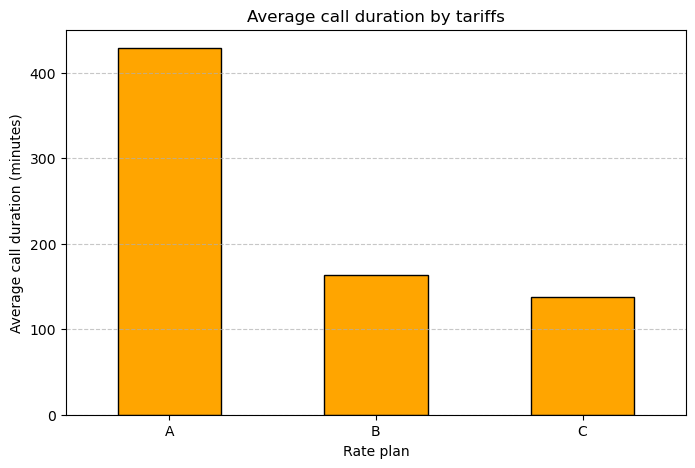

In [33]:
duration_by_tariff = df_calls_filtered.groupby('tariff_plan')['total_call_duration'].sum()
avg_duration_by_tariff = df_calls_filtered.groupby('tariff_plan')['total_call_duration'].mean()
df_duration = pd.DataFrame({'Общая длительность (минуты)': duration_by_tariff, 'Средняя длительность (минуты)': avg_duration_by_tariff})


plt.figure(figsize=(8, 5))
avg_duration_by_tariff.plot(kind='bar', color='orange', edgecolor='black')
plt.title("Average call duration by tariffs")
plt.xlabel("Rate plan")
plt.ylabel("Average call duration (minutes)")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()



- **Tariff A** - the average call lasts the longest.


-**Tariffs B and C** - calls are shorter.


All tariffs have **abnormally long** calls.

Let's touch the histogram of call duration distribution by operators

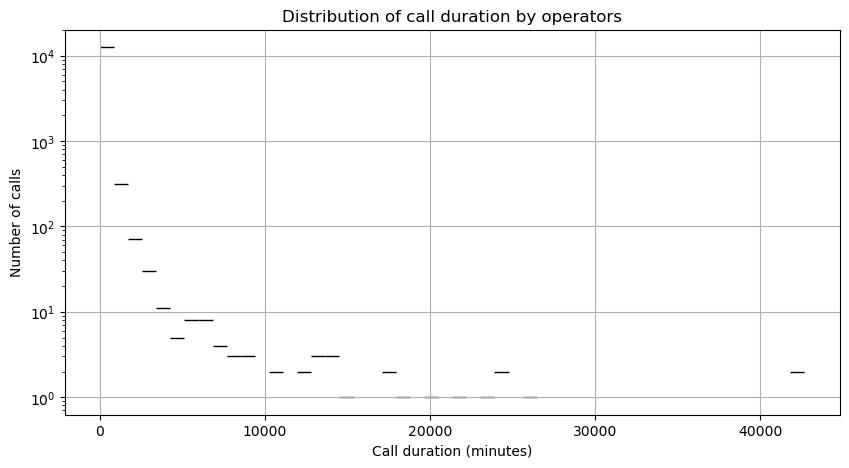

In [34]:
plt.figure(figsize=(10, 5))
sns.histplot(df_calls_filtered['total_call_duration'], bins=50, color='steelblue', edgecolor='black', log_scale=(False, True))

plt.title("Distribution of call duration by operators")
plt.xlabel("Call duration (minutes)")
plt.ylabel("Number of calls")
plt.grid()
plt.show()


Let's build a histogram of the distribution of call duration without waiting time

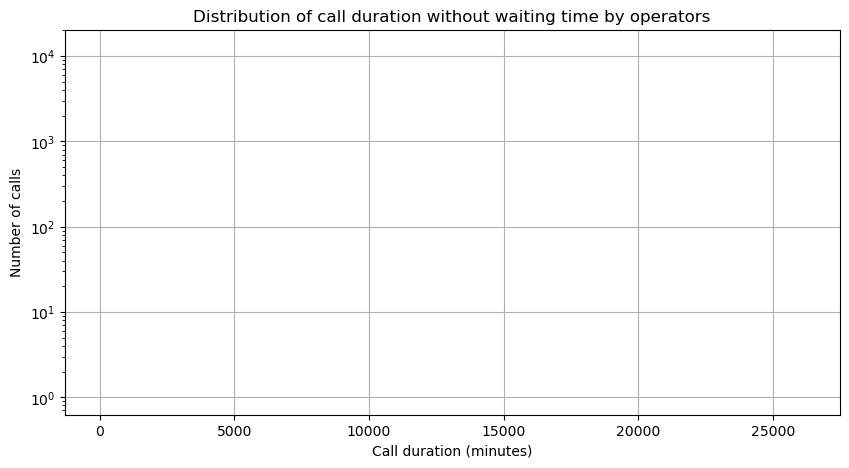

In [35]:
plt.figure(figsize=(10, 5))
sns.histplot(df_calls_filtered['call_duration'], bins=50, color='darkblue', edgecolor='black', log_scale=(False, True))

plt.title("Distribution of call duration without waiting time by operators")
plt.xlabel("Call duration (minutes)")
plt.ylabel("Number of calls")
plt.grid()
plt.show()




- Calls with unrealistically long durations are visible.
- **Without waiting, calls are shorter**, but still there are outliers with long calls.


As noted earlier, such anomalies may be cases of 24/7 operation of the company and incorrect separation (or rather lack of call separation).

Ratio of in-network to out-of-network calls by rate:

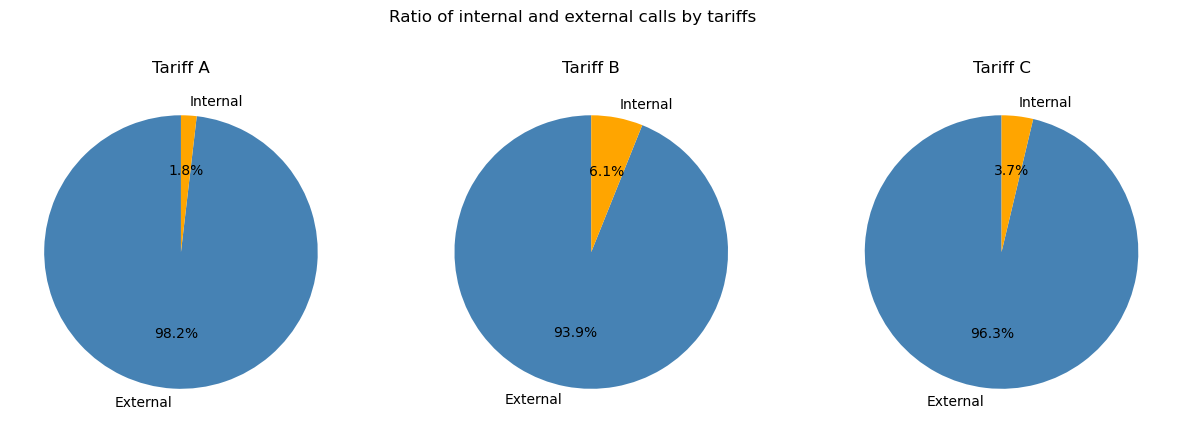

In [36]:
internal_external_calls = df_calls_filtered.groupby(['tariff_plan', 'internal'])['calls_count'].sum().unstack()

internal_external_calls.columns = ['Внешние', 'Внутренние']

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

tariffs = internal_external_calls.index
colors = ['steelblue', 'orange']

for i, tariff in enumerate(tariffs):
    axes[i].pie(
        internal_external_calls.loc[tariff],
        labels=['External', 'Internal'],
        autopct='%1.1f%%',
        colors=colors,
        startangle=90
    )
    axes[i].set_title(f"Tariff {tariff}")

plt.suptitle("Ratio of internal and external calls by tariffs")
plt.show()


- Internal calls account for less than 3% in all tariffs.
- On tariff A the share of internal calls is the lowest - only 1.9%.
- In tariffs B and C it is slightly higher, but still insignificant (2.8% and 2.2%).
- External calls prevail in all tariffs.

# Finding customers with sub-optimal tariffs

Let's find active users with suboptimal rates. with the criterion of activity in the last 6 weeks and taking into account users who joined not earlier than October:

In [37]:
filtered_df_calls = df_calls_filtered[df_calls_filtered['user_id'].isin(active_users_last_6w) | 
                                      df_calls_filtered['user_id'].isin(recent_users_oct_nov)]

remaining_users_after_filter = filtered_df_calls['user_id'].nunique()
remaining_calls_after_filter = filtered_df_calls.shape[0]

remaining_users_after_filter, remaining_calls_after_filter


(282, 12721)

In [38]:
filtered_df_calls['month'] = filtered_df_calls['date'].dt.to_period('M')

last_month = filtered_df_calls['date'].max().month
last_year = filtered_df_calls['date'].max().year

active_users = filtered_df_calls[
    (filtered_df_calls['date'].dt.month == last_month) & (filtered_df_calls['date'].dt.year == last_year)
]['user_id'].unique()

df_active_calls = filtered_df_calls[
    (filtered_df_calls['user_id'].isin(active_users)) & 
    (filtered_df_calls['month'] == f"{last_year}-{last_month}")
]

# Grouping data by users and tariffs
user_call_stats = df_active_calls.groupby(['user_id', 'tariff_plan']).agg(
    total_call_duration=('total_call_duration', 'sum'),
    total_calls=('calls_count', 'sum'),
    unique_operators=('operator_id', 'nunique'),
    external_call_duration=('total_call_duration', lambda x: x[df_active_calls['internal'] == False].sum())
).reset_index()

# Tariff details
tariff_details = {
    "A": {"monthly_fee": 4000, "included_minutes": 2000, "extra_minute_cost": 0.1, "operator_fee": 50, "external_call_cost": 0.3},
    "B": {"monthly_fee": 2000, "included_minutes": 500, "extra_minute_cost": 0.15, "operator_fee": 150, "external_call_cost": 0.5},
    "C": {"monthly_fee": 1000, "included_minutes": 0, "extra_minute_cost": 0.3, "operator_fee": 300, "external_call_cost": 0.7}
}

# Cost calculation function taking into account all tariff parameters
def calculate_cost(row):
    tariff = tariff_details[row['tariff_plan']]
    base_cost = tariff["monthly_fee"]
    extra_minutes_cost = max(0, row['total_call_duration'] - tariff["included_minutes"]) * tariff["extra_minute_cost"]
    operator_fee = row['unique_operators'] * tariff["operator_fee"]
    external_calls_cost = row['external_call_duration'] * tariff["external_call_cost"]
    
    return base_cost + extra_minutes_cost + operator_fee + external_calls_cost

user_call_stats['calculated_cost'] = user_call_stats.apply(calculate_cost, axis=1)

# Determination of sub-optimal tariffs
def find_better_tariff(row):
    current_cost = row['calculated_cost']
    best_tariff = row['tariff_plan']
    best_cost = current_cost

    for tariff, details in tariff_details.items():
        if tariff != row['tariff_plan']:
            alternative_cost = (
                details["monthly_fee"] +
                max(0, row['total_call_duration'] - details["included_minutes"]) * details["extra_minute_cost"] +
                row['unique_operators'] * details["operator_fee"] +
                row['external_call_duration'] * details["external_call_cost"]
            )
            if alternative_cost < best_cost:
                best_tariff = tariff
                best_cost = alternative_cost

    return best_tariff if best_tariff != row['tariff_plan'] else None

user_call_stats['better_tariff'] = user_call_stats.apply(find_better_tariff, axis=1)

# Filtering of users for whom the best tariff can be found
users_with_better_tariffs = user_call_stats.dropna(subset=['better_tariff'])

users_with_better_tariffs.head()

,user_id,tariff_plan,total_call_duration,total_calls,unique_operators,external_call_duration,calculated_cost,better_tariff
0,166377,B,201,29,1,201,"2,250.500",C
2,166392,C,9671,71,2,9671,"11,271.000",A
3,166405,B,30367,1377,0,30367,"21,663.550",A
4,166406,B,402,15,0,402,"2,201.000",C
7,166482,C,2698,23,2,2698,"4,298.000",B


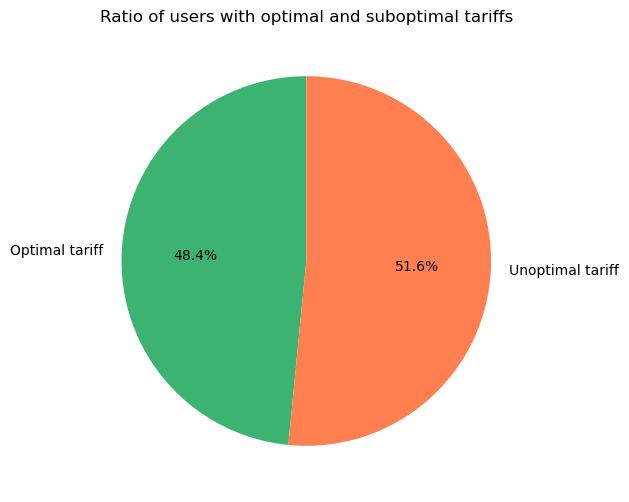

 Users with optimal tariffs: 125
 Users with suboptimal tariffs: 133
 Total active users: 258


In [39]:
# Analysis of users with optimal and sub-optimal tariffs
num_users_with_better_tariffs = users_with_better_tariffs['user_id'].nunique()

total_active_users = user_call_stats['user_id'].nunique()

num_users_with_optimal_tariffs = total_active_users - num_users_with_better_tariffs

labels = ["Optimal tariff", "Unoptimal tariff"]
sizes = [num_users_with_optimal_tariffs, num_users_with_better_tariffs]
colors = ["mediumseagreen", "coral"]

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
plt.title("Ratio of users with optimal and suboptimal tariffs")
plt.show()

print(f" Users with optimal tariffs: {num_users_with_optimal_tariffs}")
print(f" Users with suboptimal tariffs: {num_users_with_better_tariffs}")
print(f" Total active users: {total_active_users}")

In [40]:
# Count the number of users with suboptimal tariffs for each tariff plan
better_tariff_counts = users_with_better_tariffs.groupby('tariff_plan')['user_id'].nunique()

total_active_users_by_tariff = user_call_stats.groupby('tariff_plan')['user_id'].nunique()

tariff_mismatch_ratio = (better_tariff_counts / total_active_users_by_tariff) * 100

df_tariff_analysis = pd.DataFrame({
    "Total active users": total_active_users_by_tariff,
    "Suboptimal connections": better_tariff_counts,
    "Share of suboptimal connections (%)": tariff_mismatch_ratio
}).fillna(0)  


df_tariff_analysis

,Total active users,Suboptimal connections,Share of suboptimal connections (%)
tariff_plan,,,
A,30,22,73.333
B,96,68,70.833
C,132,43,32.576


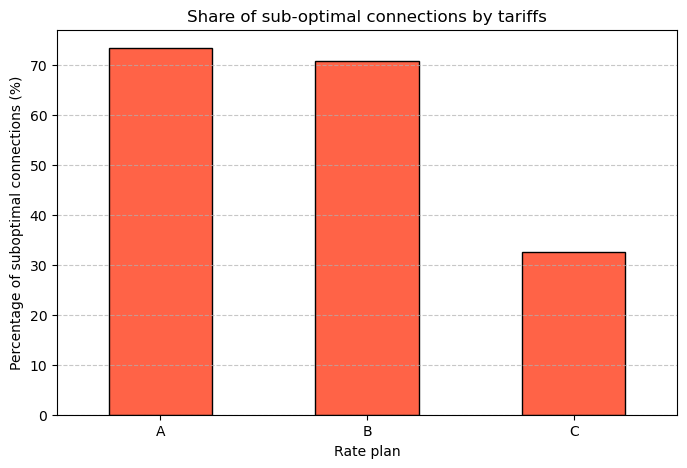

In [41]:
plt.figure(figsize=(8, 5))
df_tariff_analysis["Share of suboptimal connections (%)"].plot(kind='bar', color='tomato', edgecolor='black')

plt.title("Share of sub-optimal connections by tariffs")
plt.xlabel("Rate plan")
plt.ylabel("Percentage of suboptimal connections (%)")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


- Tariff A - the most problematic, 73% of users could change tariff and pay less.
- Tariff B - 71% of users also have a suboptimal tariff.
- Tariff C - 32.5% of users could switch to a more favorable option.

Rate allocation if all users move to optimal rates:

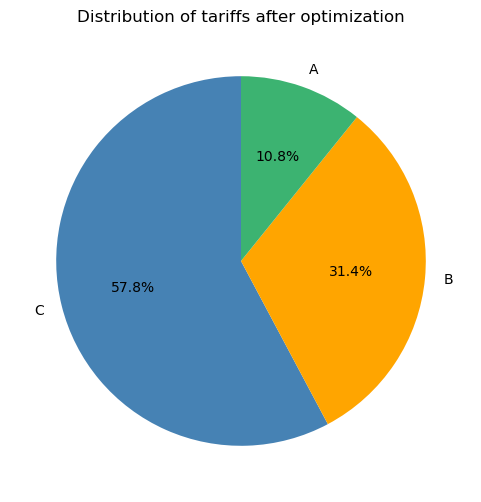

In [42]:
optimized_tariff_distribution = users_with_better_tariffs['better_tariff'].value_counts()

current_tariff_distribution = df_clients['tariff_plan'].value_counts()

new_tariff_distribution = current_tariff_distribution.copy()
for tariff, count in optimized_tariff_distribution.items():
    new_tariff_distribution[tariff] += count

for tariff, count in users_with_better_tariffs['tariff_plan'].value_counts().items():
    new_tariff_distribution[tariff] -= count

new_tariff_distribution = new_tariff_distribution.clip(lower=0)

plt.figure(figsize=(6, 6))
plt.pie(new_tariff_distribution, labels=new_tariff_distribution.index, autopct='%1.1f%%', colors=['steelblue', 'orange', 'mediumseagreen'], startangle=90)
plt.title("Distribution of tariffs after optimization")
plt.show()


- The share of tariffs A and B decreased significantly as many users switched to C.
- Tariff C became the most popular, as it turned out to be the most favorable for many customers.

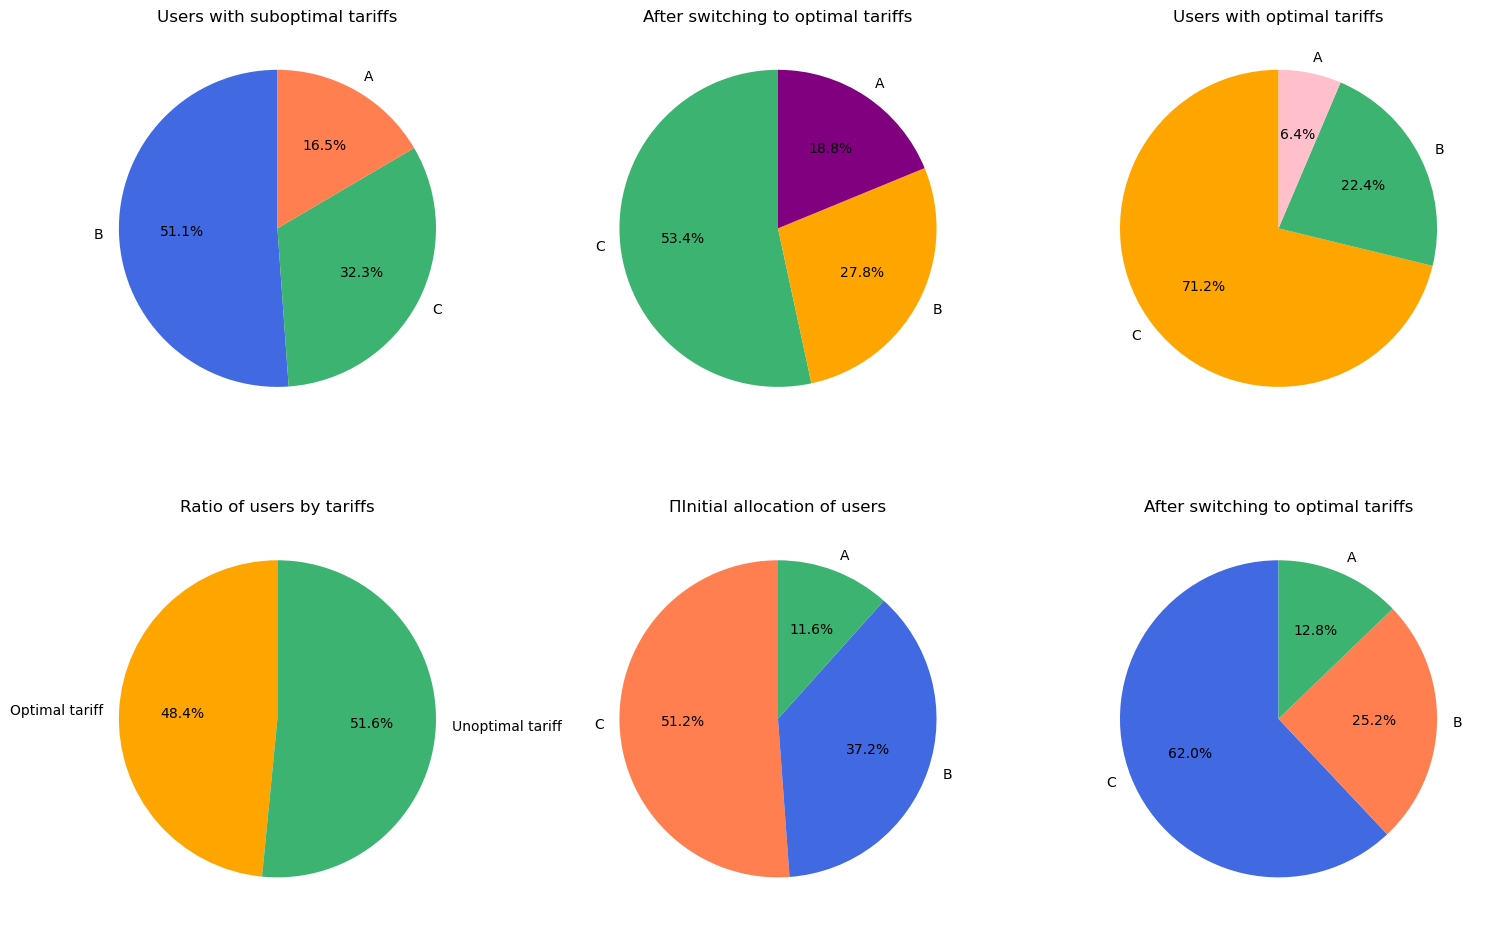

In [43]:
not_opt_current_tariffs = users_with_better_tariffs['tariff_plan'].value_counts()

not_opt_change_tariffs = users_with_better_tariffs['better_tariff'].value_counts()

opt_current_tariffs = user_call_stats[user_call_stats['better_tariff'].isna()]['tariff_plan'].value_counts()

all_users = {
    "Optimal tariff": opt_current_tariffs.sum(),
    "Unoptimal tariff": not_opt_current_tariffs.sum()
}

# Initial allocation of users to tariffs
initial_tariffs_dist = user_call_stats['tariff_plan'].value_counts()

# Distribution of users by tariffs after changing tariffs to optimal ones
best_tariffs_dist = user_call_stats['better_tariff'].fillna(user_call_stats['tariff_plan']).value_counts()

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Graph 1: Distribution of users with suboptimal tariffs
axes[0, 0].pie(not_opt_current_tariffs, labels=not_opt_current_tariffs.index, autopct='%1.1f%%', startangle=90, colors=['royalblue', 'mediumseagreen', 'coral'])
axes[0, 0].set_title("Users with suboptimal tariffs")

# Graph 2: Distribution after switching to optimal tariffs
axes[0, 1].pie(not_opt_change_tariffs, labels=not_opt_change_tariffs.index, autopct='%1.1f%%', startangle=90, colors=['mediumseagreen','orange', 'purple'])
axes[0, 1].set_title("After switching to optimal tariffs")

# Graph 3: Distribution of users with optimal tariffs
axes[0, 2].pie(opt_current_tariffs, labels=opt_current_tariffs.index, autopct='%1.1f%%', startangle=90, colors=['orange', 'mediumseagreen', 'pink'])
axes[0, 2].set_title("Users with optimal tariffs")

# Chart 4: Ratio of users with suboptimal to optimal tariffs
axes[1, 0].pie(all_users.values(), labels=all_users.keys(), autopct='%1.1f%%', startangle=90, colors=['orange', 'mediumseagreen'])
axes[1, 0].set_title("Ratio of users by tariffs")

# Graph 5: Initial distribution of users by tariff
axes[1, 1].pie(initial_tariffs_dist, labels=initial_tariffs_dist.index, autopct='%1.1f%%', startangle=90, colors=['coral', 'royalblue', 'mediumseagreen'])
axes[1, 1].set_title("ПInitial allocation of users")

# Graph 6: Distribution of users after switching to optimal tariffs
axes[1, 2].pie(best_tariffs_dist, labels=best_tariffs_dist.index, autopct='%1.1f%%', startangle=90, colors=['royalblue', 'coral', 'mediumseagreen'])
axes[1, 2].set_title("After switching to optimal tariffs")

plt.tight_layout()
plt.show()


# Determine the loss in revenue when all customers switch to optimal tariffs

In [44]:
current_revenue = user_call_stats['calculated_cost'].sum()

def calculate_new_cost(row):
    if pd.notna(row['better_tariff']):  
        new_tariff = tariff_details[row['better_tariff']]
        return new_tariff["monthly_fee"] + max(0, row['total_call_duration'] - new_tariff["included_minutes"]) * new_tariff["extra_minute_cost"]
    return row['calculated_cost']  

user_call_stats['optimized_cost'] = user_call_stats.apply(calculate_new_cost, axis=1)
optimized_revenue = user_call_stats['optimized_cost'].sum()

revenue_loss = current_revenue - optimized_revenue
revenue_loss_percentage = (revenue_loss / current_revenue) * 100

revenue_loss, revenue_loss_percentage


(463942.6499999999, 33.26278218562131)

Loss in average monthly revenue when all customers switch to optimal tariffs:
- Total loss: 463942.70 ₽
- Percentage decrease in revenue: 33%


Conclusions:
- If all customers switch to more favorable tariffs, revenue will decrease by 33%.
- The current tariff structure generates more revenue as users overpay.

In [45]:
# Table with customers, their current tariffs and recommended new tariffs
df_final_recommendations = users_with_better_tariffs[['user_id', 'tariff_plan', 'better_tariff']].rename(
    columns={'tariff_plan': 'Старый тариф', 'better_tariff': 'Новый тариф'}
)

df_final_recommendations.head()

,user_id,Старый тариф,Новый тариф
0,166377,B,C
2,166392,C,A
3,166405,B,A
4,166406,B,C
7,166482,C,B


# Statistical hypothesis testing

Hypothesis 1: Customers with suboptimal tariffs pay significantly more than they would if they used the optimal tariff
- H₀ (null hypothesis): The average communication cost of users with suboptimal tariffs does not differ from the cost at the optimal tariff.
- H₁ (alternative hypothesis): The average communication cost of users with suboptimal tariffs is significantly higher than that of the optimal tariff.

In [46]:
# We use the Shapiro-Wilk test to check the normality of the distribution
shapiro_test_current = shapiro(user_call_stats['calculated_cost'])
shapiro_test_optimized = shapiro(user_call_stats['optimized_cost'])

print("Shapiro-Wilk test (test of normality of data)")
print(f"Current communication value: p-value = {shapiro_test_current.pvalue:.2e}")
print(f"Optimal communication cost: p-value = {shapiro_test_optimized.pvalue:.2e}")



Shapiro-Wilk test (test of normality of data)
Current communication value: p-value = 3.91e-32
Optimal communication cost: p-value = 3.34e-33


Both samples do NOT have a normal distribution (p-value < 0.05), so a t-test cannot be used.

In [52]:
wilcoxon_test = wilcoxon(user_call_stats['calculated_cost'], user_call_stats['optimized_cost'])

# Output the result of the Wilcoxon test
print("\n Results of the Wilcoxon test (testing for differences in costs)")
print(f"P-value = {wilcoxon_test.pvalue:.2e}")

if wilcoxon_test.pvalue < 0.05:
    print("**Hypothesis H₀ is rejected** - users with suboptimal tariffs pay significantly more.")
    print(" The difference in communication costs is statistically significant.")
else:
    print("**Hypothesis H₀ is not rejected** - there are no differences in communication costs.")



 Results of the Wilcoxon test (testing for differences in costs)
P-value = 1.43e-23
**Hypothesis H₀ is rejected** - users with suboptimal tariffs pay significantly more.
 The difference in communication costs is statistically significant.


In [53]:
wilcoxon_test = wilcoxon(user_call_stats['calculated_cost'], user_call_stats['optimized_cost'])

# Calculate the differences between the values
differences = user_call_stats['calculated_cost'] - user_call_stats['optimized_cost']

p_value_one_sided = wilcoxon_test.pvalue / 2 #we divide significance by 2, because we test the one-sided hypothesis

# Output the result of the one-sided Wilcoxon test
print("\nResults of one-sided Wilcoxon test (verifying that costs are HIGHER at the sub-optimal tariff)")
print(f"P-value (односторонний) = {p_value_one_sided:.2e}")

if p_value_one_sided < 0.05:
    print("**Hypothesis H₀ is rejected** - users with suboptimal tariffs pay SIGNIFICANTLY MORE.")
    print("The difference in communication costs is statistically significant.")
else:
    print("**Hypothesis H₀ is not rejected** - users with suboptimal tariffs do not pay more.")


Results of one-sided Wilcoxon test (verifying that costs are HIGHER at the sub-optimal tariff)
P-value (односторонний) = 7.14e-24
**Hypothesis H₀ is rejected** - users with suboptimal tariffs pay SIGNIFICANTLY MORE.
The difference in communication costs is statistically significant.


In [55]:
wilcoxon_test = wilcoxon(user_call_stats['calculated_cost'], user_call_stats['optimized_cost'])

from scipy.stats import wilcoxon

# One-sided Wilcoxon test (check that calculated_cost is greater than optimized_cost)
wilcoxon_test = wilcoxon(user_call_stats['calculated_cost'], user_call_stats['optimized_cost'], alternative='greater')

# Output the results
print("\nResults of one-sided Wilcoxon test (verifying that costs are HIGHER at the suboptimal tariff))")
print(f"P-value (односторонний) = {wilcoxon_test.pvalue:.2e}")

if wilcoxon_test.pvalue < 0.05:
    print("**Hypothesis H₀ is rejected** - users with suboptimal tariffs pay SIGNIFICANTLY MORE.")
    print("The difference in communication costs is statistically significant.")
else:
    print("**Hypothesis H₀ is not rejected** - users with suboptimal tariffs do not pay more.")


Results of one-sided Wilcoxon test (verifying that costs are HIGHER at the suboptimal tariff))
P-value (односторонний) = 7.14e-24
**Hypothesis H₀ is rejected** - users with suboptimal tariffs pay SIGNIFICANTLY MORE.
The difference in communication costs is statistically significant.


Hypothesis: Customers who frequently exceed their minute limits spend more on communication than customers who stay within the limit.


- H₀ (null hypothesis): The average communication cost of customers exceeding the minutes limits is not different from the average cost of the rest of the users.


- H₁ (alternative hypothesis): Customers who go over the minutes limits spend significantly more on communication than those who stay within the tariff package.

In [56]:
user_call_stats_filtered = df_calls_filtered.groupby(['user_id', 'tariff_plan']).agg(
    total_call_duration=('total_call_duration', 'sum'),
    total_calls=('calls_count', 'sum'),
    unique_operators=('operator_id', 'nunique'),
    external_call_duration=('total_call_duration', lambda x: x[df_calls_filtered['internal'] == False].sum())
).reset_index()

# Determination of minutes overage based on the tariff
user_call_stats_filtered['limit_exceeded'] = user_call_stats_filtered.apply(
    lambda row: row['total_call_duration'] > tariff_details[row['tariff_plan']]["included_minutes"], axis=1
)

# Cost calculation function taking into account all tariff parameters
def calculate_full_cost(row):
    tariff = tariff_details[row['tariff_plan']]
    base_cost = tariff["monthly_fee"]
    extra_minutes_cost = max(0, row['total_call_duration'] - tariff["included_minutes"]) * tariff["extra_minute_cost"]
    operator_fee = row['unique_operators'] * tariff["operator_fee"]
    external_calls_cost = row['external_call_duration'] * tariff["external_call_cost"]
    
    return base_cost + extra_minutes_cost + operator_fee + external_calls_cost

user_call_stats_filtered['calculated_cost'] = user_call_stats_filtered.apply(calculate_full_cost, axis=1)

user_costs_filtered = user_call_stats_filtered.groupby(['user_id', 'limit_exceeded'])['calculated_cost'].mean().reset_index()

group_over_limit_filtered = user_costs_filtered[user_costs_filtered['limit_exceeded'] == True]['calculated_cost']
group_within_limit_filtered = user_costs_filtered[user_costs_filtered['limit_exceeded'] == False]['calculated_cost']

# Test of normality of distribution (Shapiro-Wilk test))
shapiro_over_filtered = st.shapiro(group_over_limit_filtered)
shapiro_within_filtered = st.shapiro(group_within_limit_filtered)

shapiro_over_filtered.pvalue, shapiro_within_filtered.pvalue


(9.32913626173682e-31, 6.45178066426811e-08)



We use the Mann-Whitney criterion because the samples are independent and the data distribution is not normal.

In [57]:
# Since the data is not normal, we use the Mann-Whitney criterion

mann_whitney_test = st.mannwhitneyu(group_over_limit_filtered, group_within_limit_filtered, alternative='greater')

print("Результаты теста Манна-Уитни (проверка различий в затратах)")
print(f"Статистика теста: {mann_whitney_test.statistic:.2f}, p-value = {mann_whitney_test.pvalue:.2e}")

alpha = 0.05  # Statistical significance level
if mann_whitney_test.pvalue < alpha:
    print("Hypothesis H₀ is rejected - customers exceeding minute limits do spend more.")
else:
    print("Hypothesis H₀ is not rejected - there are no differences in communication costs.")


Результаты теста Манна-Уитни (проверка различий в затратах)
Статистика теста: 7598.00, p-value = 2.34e-06
Hypothesis H₀ is rejected - customers exceeding minute limits do spend more.


- You can create additional options and flexible packages so that customers do not change their tariff, but can buy additional minutes.
- You can target these customers by offering packages of additional minutes instead of changing the tariff.

## Overall project output


## Data preprocessing and anomaly detection
- Adjusted the data to the required format, removed 4900 duplicates and processed 7456 omissions in ` operator_id`, most of them related to missed calls.
- Found out that there are 732 customers in the database, but only 307 actually make calls.
- We detected abnormal clients whose operators talked for more than 24 hours a day.
- We excluded these operators from the analysis because their data may be erroneous or related to peculiarities of operation (e.g., 24-hour operation or technical problems).


## General analysis of calls and tariffs
- There are more outgoing calls than incoming calls, which confirms the active use of communication by customers.
- The number of calls drops on weekends, probably due to a decrease in business activity.
- Tariff A is the most popular, while tariff B is most often suboptimal.
- Average call duration varies by tariff:
- Tariff A - average call duration 428 minutes.
- Tariffs B and C - shorter calls (≈163 and 137 minutes respectively).


## Data errors and abnormal calls
- Abnormally long calls have been detected.
- This indicates possible data accounting errors where calls were not segregated into separate calls.


## Analysis of sub-optimal tariffs
- More than half of users could pay less by choosing a different tariff.
- If all customers switched to favorable tariffs, the company's revenue would decrease by 33% (~463942₽ per month).
- On tariff A, 74% of customers overpay, making it the most disadvantageous for users.
- External calls dominate in all tariffs, internal calls account for less than 3%.


## Statistical hypothesis testing
- **Hypothesis 1: Customers with suboptimal rates pay more**
- The Wilcoxon test showed that the difference is statistically significant.
- Users with suboptimal tariffs do overpay.


- **Hypothesis 2: Customers exceeding minute limits spend more**
- The Mann-Whitney test confirmed that such customers do spend more.
- This suggests that such users may be a target audience for additional minute packages.


## Recommendations
**How to reduce revenue losses when switching to favorable tariffs?
- Introduce flexible tariff plans with the option to buy more minutes.
- Create personalized offers to customers to keep them on current tariffs.
- Monetize additional services (call analytics, priority connection, corporate packages).




The project showed that a significant part of customers overpay, and the company may lose some revenue when switching to optimal tariffs. However, with the right strategy it is possible to maintain revenue and improve customer experience.
